# Expectations for the Chi2-gof test

We have made a linear regression based on mutations per Mbp and we have found gene-weights (how often each gene has been tested in the different age-intervals). I want to these into one vector of expected frequencies for the different age-intervals, which is the to be used in the chi2-gof test. One test will be general, dividing expectations into sex and sample-type, and 18 will be cancer-specific.

## Setup

In [32]:
library("ggplot2")
library("dplyr")

## Loading General Data

In [33]:
# We define our age-interval order
age_interval_levels <- c('<45',
                         '[45-55[',
                         '[55-65[',
                         '[65-75[',
                         '>=75')

In [34]:
# We load in our general gene weights
general_gene_weights <- read.csv("../../derived_data/gene_weight_by_age_sex_sample_type.csv", header=TRUE, stringsAsFactors=FALSE)

# We remove an unnecessary column containing indexes
general_gene_weights <- general_gene_weights %>% select(-X)

# We make the age_interval column follow the age-interval levels as defined previously
general_gene_weights$age_interval <- factor(general_gene_weights$age_interval, levels=age_interval_levels)

# We check the result
dim(general_gene_weights)
head(general_gene_weights)

[1] 43124     5

,Hugo_Symbol,age_interval,SEX,SAMPLE_TYPE,gene_panel_count
,<chr>,<fct>,<chr>,<chr>,<int>
1,MUTYH,<45,Male,Primary,114
2,FGF19,<45,Male,Primary,114
3,DDR2,<45,Male,Primary,114
4,HRAS,<45,Male,Primary,114
5,CDKN2A,<45,Male,Primary,114
6,TP53,<45,Male,Primary,114


In [35]:
# We load in our general linear expectation
general_linear_expectation <- read.csv("../../derived_data/linear_expectation_full.csv", header=TRUE, stringsAsFactors=FALSE)

# We remove an unnecessary column containing indexes
general_linear_expectation <- general_linear_expectation %>% select(-X)

# We make the age_interval column follow the age-interval levels as defined previously
general_linear_expectation$age_interval <- factor(general_linear_expectation$age_interval, levels=age_interval_levels)

# We check the result
dim(general_linear_expectation)
head(general_linear_expectation)

[1] 20  5

,SEX,SAMPLE_TYPE,age_interval,mean_exp,freq
,<chr>,<chr>,<fct>,<dbl>,<dbl>
1,Female,Metastasis,<45,0.3879895,0.1628642
2,Female,Metastasis,[45-55[,0.4421465,0.1855974
3,Female,Metastasis,[55-65[,0.4802601,0.2015961
4,Female,Metastasis,[65-75[,0.5126439,0.2151897
5,Female,Metastasis,>=75,0.5592488,0.2347527
6,Female,Primary,<45,0.3152943,0.1517526


## General Expectation

In [36]:
# Gene-specific weigts as frequencies

general_gene_weights <- general_gene_weights %>% group_by(Hugo_Symbol, SEX, SAMPLE_TYPE) %>% mutate(gene_freq = gene_panel_count/sum(gene_panel_count))

# Linear expectations as frequencies
# We add one to avaoid multiplying two tiny frequencies later
general_linear_expectation <- general_linear_expectation %>% group_by(SEX, SAMPLE_TYPE) %>% mutate(linear_freq = (mean_exp/sum(mean_exp))+1)


In [37]:
# We create a temporary dataframe with our linear expectations as frequencies
tmp1 <- general_linear_expectation %>% select(-mean_exp)

# We join the gene-weights to our temporary dataframe by age, sex and sample type, creating our expectation dataframe
general_expectation <- left_join(general_gene_weights, tmp1, by = c("age_interval", "SEX", "SAMPLE_TYPE"))

# Then we calculate the product of the gene-weight and linear-frequency, calling it the temporary hypothesis frequency
general_expectation <- general_expectation %>% mutate(tmp_hypothesis_freq = gene_freq * linear_freq)

# We have to normalise the hypothesis frequency to be usefull
general_expectation <- general_expectation %>% group_by(Hugo_Symbol, SEX, SAMPLE_TYPE) %>% mutate(hypothesis_freq = tmp_hypothesis_freq/sum(tmp_hypothesis_freq))

# We remove our old temporary hypothesis frequency
general_expectation <- general_expectation %>% select(-tmp_hypothesis_freq)

In [38]:
# We check the result
head(general_expectation)

Hugo_Symbol,age_interval,SEX,SAMPLE_TYPE,gene_panel_count,gene_freq,freq,linear_freq,hypothesis_freq
<chr>,<fct>,<chr>,<chr>,<int>,<dbl>,<dbl>,<dbl>,<dbl>
MUTYH,<45,Male,Primary,114,0.3551402,0.1477591,1.147759,0.3418843
FGF19,<45,Male,Primary,114,0.3551402,0.1477591,1.147759,0.3418843
DDR2,<45,Male,Primary,114,0.3551402,0.1477591,1.147759,0.3418843
HRAS,<45,Male,Primary,114,0.3551402,0.1477591,1.147759,0.3418843
CDKN2A,<45,Male,Primary,114,0.3551402,0.1477591,1.147759,0.3418843
TP53,<45,Male,Primary,114,0.3551402,0.1477591,1.147759,0.3418843


In [39]:
# We want to filter our mutations to only those where one frequency is present for each age-sex-sample group

# We do this by creating a table counting how many times each gene has an enty in our expectation dataframe
filter <- table(general_expectation$Hugo_Symbol)

# We make it a data-frame to make things easier for us
filter <- as.data.frame(filter)

# Only genes with 20 entries, one for each sex (2), sample-type (2) and age-interval (5) combination, are we interested in
# We therefore only keep genes with 20 entries in our filter
filter <- filter[which(filter$Freq == 20),]

# We create a keep list of the gene-names that meet our criteria
keep <- list(filter$Var1)[[1]]

# We check the length of that list
length(keep)

[1] 2056

In [40]:
# We apply the filter, only keeping expectations where the gene is present in our keep list
general_expectation <- general_expectation[which(general_expectation$Hugo_Symbol %in% keep),]

In [41]:
head(general_linear_expectation)

SEX,SAMPLE_TYPE,age_interval,mean_exp,freq,linear_freq
<chr>,<chr>,<fct>,<dbl>,<dbl>,<dbl>
Female,Metastasis,<45,0.3879895,0.1628642,1.162864
Female,Metastasis,[45-55[,0.4421465,0.1855974,1.185597
Female,Metastasis,[55-65[,0.4802601,0.2015961,1.201596
Female,Metastasis,[65-75[,0.5126439,0.2151897,1.215190
Female,Metastasis,>=75,0.5592488,0.2347527,1.234753
Female,Primary,<45,0.3152943,0.1517526,1.151753


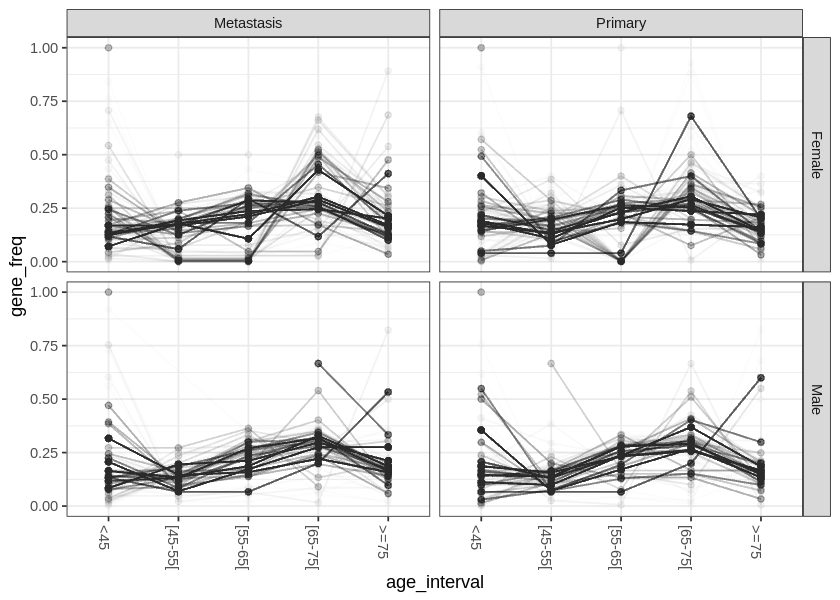

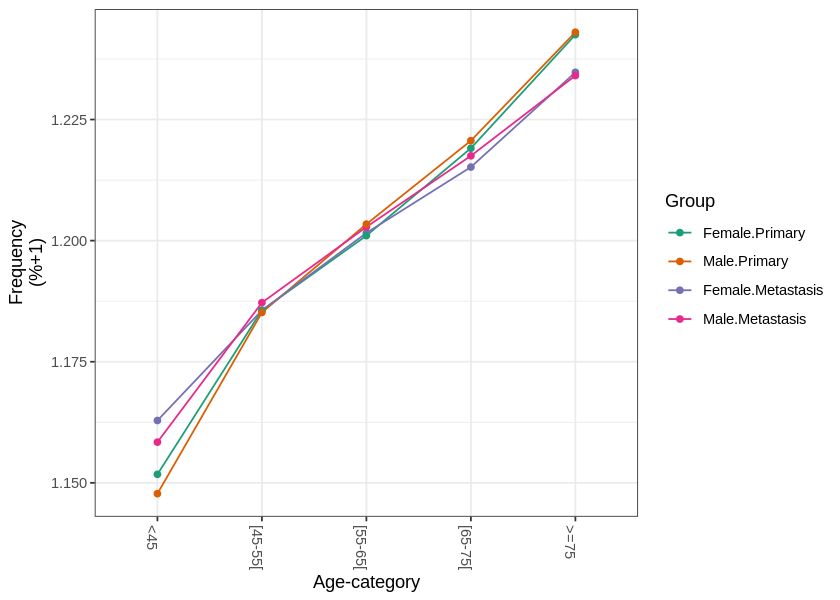

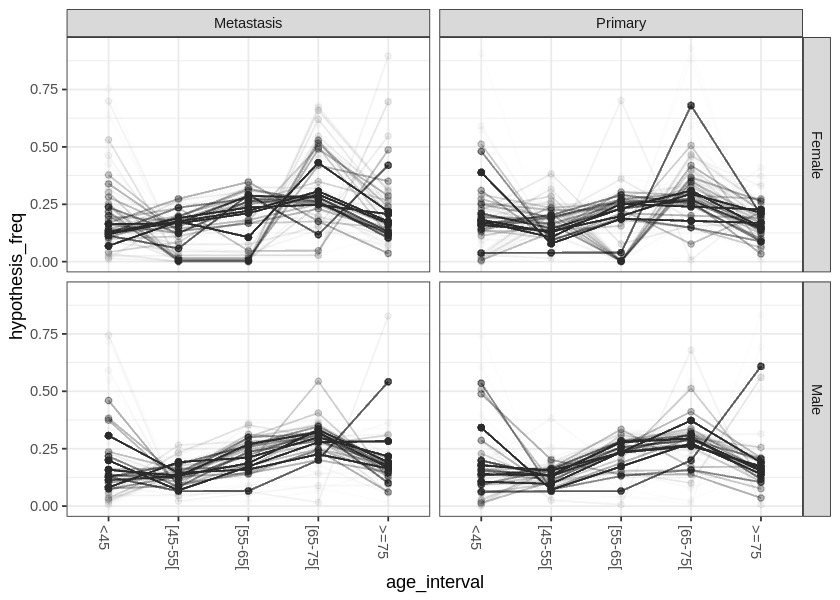

In [45]:
options(repr.plot.width=7, repr.plot.height=5)

# Plotting gene-weights
ggplot(general_gene_weights, aes(x = age_interval, y = gene_freq, group=Hugo_Symbol)) +
  geom_line(alpha=1/100) +
  geom_point(alpha=1/100) +
  theme_bw() +
  facet_grid(vars(SEX), vars(SAMPLE_TYPE)) +
  theme(axis.text.x=element_text(angle = -90, hjust = 0))

general_linear_expectation$SEX <- factor(general_linear_expectation$SEX, levels = c("Female", "Male"))
general_linear_expectation$SAMPLE_TYPE <- factor(general_linear_expectation$SAMPLE_TYPE, levels = c("Primary", "Metastasis"))

# Plotting linear-expectation
ggplot(general_linear_expectation, aes(x = age_interval, y = linear_freq, group=interaction(SEX, SAMPLE_TYPE), colour=interaction(SEX, SAMPLE_TYPE))) +
geom_line() +
geom_point() +
theme_bw() +
scale_color_brewer(palette = "Dark2") +
xlab('Age-category') +
ylab('Frequency\n(%+1)')  +
labs(colour='Group') +
theme_bw() +
theme(axis.text.x=element_text(angle = -90, hjust = 0))

# Plotting expectation
ggplot(general_expectation, aes(x = age_interval, y = hypothesis_freq, group=Hugo_Symbol)) +
  geom_line(alpha=1/100) +
  geom_point(alpha=1/100) +
  theme_bw() +
  facet_grid(vars(SEX), vars(SAMPLE_TYPE)) +
  theme(axis.text.x=element_text(angle = -90, hjust = 0))

In [11]:
# We make our expectation dataframe slightly smaller so it only contains our hypothesis frequencies, not gene-weights or linear expectations
general_expectation <- general_expectation %>% select("Hugo_Symbol", "age_interval", "SEX", "SAMPLE_TYPE", "hypothesis_freq")

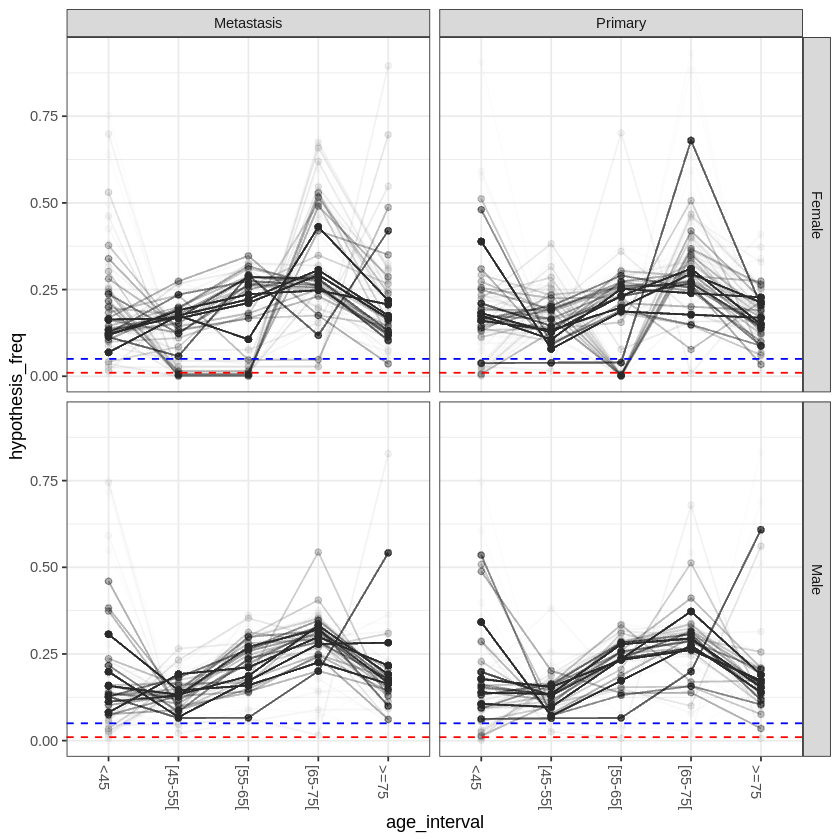

In [12]:
# Plotting expectations
ggplot(general_expectation, aes(x = age_interval, y = hypothesis_freq, group=Hugo_Symbol)) +
  geom_line(alpha=1/100) +
  geom_point(alpha=1/100) +
  theme_bw() +
  facet_grid(vars(SEX), vars(SAMPLE_TYPE)) +
  theme(axis.text.x=element_text(angle = -90, hjust = 0))  +
  geom_hline(yintercept=0.01, linetype="dashed", color = "red") +
  geom_hline(yintercept=0.05, linetype="dashed", color = "blue")

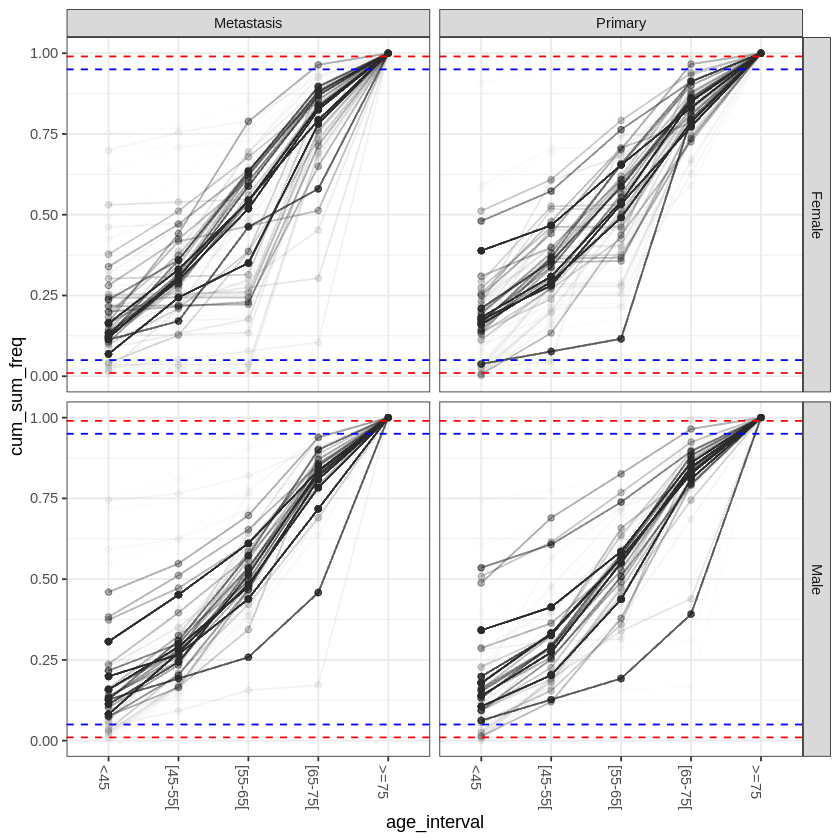

In [13]:
# Plotting a cumsum plot

# We calculate the cumulative sum of the hypothesis frequencies
tmp <- general_expectation %>% group_by(Hugo_Symbol, SEX, SAMPLE_TYPE) %>% mutate(cum_sum_freq = cumsum(hypothesis_freq))

# The acctual cum-sum plot
ggplot(tmp, aes(x = age_interval, y = cum_sum_freq, group=Hugo_Symbol)) +
  geom_line(alpha=1/100) +
  geom_point(alpha=1/100) +
  theme_bw() +
  facet_grid(vars(SEX), vars(SAMPLE_TYPE)) +
  theme(axis.text.x=element_text(angle = -90, hjust = 0)) +
  geom_hline(yintercept=0.01, linetype="dashed", color = "red") +
  geom_hline(yintercept=0.05, linetype="dashed", color = "blue")  +
  geom_hline(yintercept=0.99, linetype="dashed", color = "red") +
  geom_hline(yintercept=0.95, linetype="dashed", color = "blue")

### Checking Chi2-gof assumptions

In [14]:
# Checking ecpectations
head(general_expectation)

Hugo_Symbol,age_interval,SEX,SAMPLE_TYPE,hypothesis_freq
<chr>,<fct>,<chr>,<chr>,<dbl>
MUTYH,<45,Male,Primary,0.3418843
FGF19,<45,Male,Primary,0.3418843
DDR2,<45,Male,Primary,0.3418843
HRAS,<45,Male,Primary,0.3418843
CDKN2A,<45,Male,Primary,0.3418843
TP53,<45,Male,Primary,0.3418843


In [15]:
# Checking assumptions

# We create an ampty list to hold genes that do not match our assumptions
not_applicable <- list()

# We loop through each mutation in our expectations data-frame
for (mutation in unique(general_expectation$Hugo_Symbol)){
    
    # We create a smaller temporary data-frame containing only the current mutation we are looping through
    tmp1 <- general_expectation[which(general_expectation$Hugo_Symbol==mutation),]
    
    # We loop through each sex
    for (sex in c('Male','Female')){
        
        # Further limit our search to a new temporary dataframe containing only our mutation and sex
        # This needs to be another dataframe to make sure we can loop back and do the same for the other sex
        tmp2 <- tmp1[which(tmp1$SEX==sex),]
        
        # We loop through each sample-type
        for (sample_type in c('Primary','Metastasis')){
            
            # We apply the final filter and get our gene-frequencies
            gene_freq <- tmp2[which(general_expectation$SAMPLE_TYPE==sample_type),]
            
            # We count how many entries have a hypothesis-frequency less-than-or-equal-to 1%
            leq_one <- dim(gene_freq[which(gene_freq$hypothesis_freq <= 0.01),5])[1]
            
            # We count how many entries have a hypothesis-frequency less-than-or-equal-to 5%
            leq_five <- dim(gene_freq[which(gene_freq$hypothesis_freq <= 0.05),5])[1]
            
            # If there is more than one (20% of 5 is 1) entry with leq 5% in hypothetical frequency
            # Or even one entry with leq 1% in hypothetical frequency
            # We do not abide the assumptions to the chi2-gof test
            if (leq_five > 1 | leq_one >= 1){ 
                
                # We add the mutation to our not-applicable list
                not_applicable[[length(not_applicable)+1]] <- mutation 
            }            
        }
    }
}

# We check how many genes were in the original expectation list
length(unique(general_expectation$Hugo_Symbol))

# And how many are left after removing genes that do not fit our assumptions
length(unique(general_expectation$Hugo_Symbol)) - length(unique(not_applicable))

[1] 2056

[1] 1691

In [16]:
# We remove the genes that we found did not fit our assumptions
general_expectation <- general_expectation[!(general_expectation$Hugo_Symbol %in% unique(not_applicable)),]

# We check the number of genes after applying our filter
length(unique(general_expectation$Hugo_Symbol))

[1] 1691

In [17]:
# We save the results
write.csv(general_expectation, "../../derived_data/chi2_gof_test_expectations/general.csv", row.names=TRUE)

## Cancer-specific expectations

In [18]:
# We have a list of our different cancer-types
cancer_list <- c('Bladder Cancer',
                 'Breast Cancer',
                 'Cancer of Unknown Primary',
                 'Colorectal Cancer',
                 'Endometrial Cancer',
                 'Esophagogastric Cancer',
                 'Glioma',
                 'Head and Neck Cancer',
                 'Hepatobiliary Cancer',
                 'Mature B-Cell Neoplasms',
                 'Melanoma',
                 'Non-Small Cell Lung Cancer',
                 'Ovarian Cancer',
                 'Pancreatic Cancer',
                 'Prostate Cancer',
                 'Renal Cell Carcinoma',
                 'Soft Tissue Sarcoma',
                 'Thyroid Cancer')

In [19]:
# We have a list of our cancer-specific-gene-weight file-names
cancer_gene_weights <- c('csgw_Bladder_Cancer.csv',
                         'csgw_Breast_Cancer.csv',
                         'csgw_Cancer_of_Unknown_Primary.csv',
                         'csgw_Colorectal_Cancer.csv',
                         'csgw_Endometrial_Cancer.csv',
                         'csgw_Esophagogastric_Cancer.csv',
                         'csgw_Glioma.csv',
                         'csgw_Head_and_Neck_Cancer.csv',
                         'csgw_Hepatobiliary_Cancer.csv',
                         'csgw_Mature_B_Cell_Neoplasms.csv',
                         'csgw_Melanoma.csv',
                         'csgw_Non_Small_Cell_Lung_Cancer.csv',
                         'csgw_Ovarian_Cancer.csv',
                         'csgw_Pancreatic_Cancer.csv',
                         'csgw_Prostate_Cancer.csv',
                         'csgw_Renal_Cell_Carcinoma.csv',
                         'csgw_Soft_Tissue_Sarcoma.csv',
                         'csgw_Thyroid_Cancer.csv')

In [20]:
# We load-in the linear expectation
cancer_linear_expectation <- read.csv("../../derived_data/linear_expectation_by_cancer_mean.csv", header=TRUE, stringsAsFactors=FALSE)

# We remove an old index column
cancer_linear_expectation <- cancer_linear_expectation %>% select(-X)

# We define the age-interval order
cancer_linear_expectation$age_interval <- factor(cancer_linear_expectation$age_interval, levels=age_interval_levels)

# We check the data
dim(cancer_linear_expectation)
head(cancer_linear_expectation)

[1] 310   5

,CANCER_TYPE,SEX,SAMPLE_TYPE,age_interval,mean_exp
,<chr>,<chr>,<chr>,<fct>,<dbl>
1,Bladder Cancer,Female,Metastasis,<45,0.4779929
2,Bladder Cancer,Female,Metastasis,[45-55[,0.5639584
3,Bladder Cancer,Female,Metastasis,[55-65[,0.5724783
4,Bladder Cancer,Female,Metastasis,[65-75[,0.6356537
5,Bladder Cancer,Female,Metastasis,>=75,0.6863598
6,Bladder Cancer,Female,Primary,<45,0.4496032


In [21]:
# We repeat the calculation of hypothesis frequencies, 
# but for each cancer-type

for (idx in 1:length(cancer_list)){
    
    # Loading linear expectations
    name <- cancer_list[idx]
    linear_expectation <- cancer_linear_expectation[which(cancer_linear_expectation$CANCER_TYPE==name),]
    
    # Calculating linear expectation
    linear_expectation <- linear_expectation %>% group_by(CANCER_TYPE, SEX, SAMPLE_TYPE) %>% mutate(linear_freq = (mean_exp/sum(mean_exp))+1)
    
    # Loading gene-specific weights
    gene_weight_file <- cancer_gene_weights[idx]
    path <- paste('../../derived_data/cancer_specific_gene_weights/', gene_weight_file, sep='')
    gene_weights <- read.csv(path, header=TRUE, stringsAsFactors=FALSE)
    
    # Wrangling a little
    gene_weights <- gene_weights %>% select(-X)
    gene_weights$age_interval <- factor(gene_weights$age_interval, levels=age_interval_levels)
    
    # Calculating the gene-specific weights
    gene_weights <- gene_weights %>% group_by(CANCER_TYPE, Hugo_Symbol, SEX, SAMPLE_TYPE) %>% mutate(gene_freq = gene_panel_count/sum(gene_panel_count))
    
    # Calculating the hypothesis frequency
    tmp1 <- linear_expectation %>% select(-mean_exp)
    expectation <- left_join(gene_weights, tmp1, by = c("CANCER_TYPE", "age_interval", "SEX", "SAMPLE_TYPE"))
    expectation <- expectation %>% mutate(tmp_hypothesis_freq = gene_freq * linear_freq)
    expectation <- expectation %>% group_by(Hugo_Symbol, SEX, SAMPLE_TYPE) %>% mutate(hypothesis_freq = tmp_hypothesis_freq/sum(tmp_hypothesis_freq))
    expectation <- expectation %>% select(-tmp_hypothesis_freq)
    
    # Filtering for genes where all expectations are known
    
    # If it is a cancer-type with only one sex the frequency need only be 10
    if (name == 'Endometrial Cancer' | name == 'Ovarian Cancer' | name == 'Prostate Cancer'){
        filter <- table(expectation$Hugo_Symbol)
        filter <- as.data.frame(filter)
        filter <- filter[which(filter$Freq == 10),]
        keep <- list(filter$Var1)[[1]]
        
        # Applying the filter
        expectation <- expectation[which(expectation$Hugo_Symbol %in% keep),]

        # Making the table slightly smaller
        expectation <- expectation %>% select("CANCER_TYPE", "Hugo_Symbol", "age_interval", "SEX", "SAMPLE_TYPE", "hypothesis_freq")

        # Checking Chi2-gof assumptions
        not_applicable <- list()

        for (mutation in unique(expectation$Hugo_Symbol)){
            tmp1 <- expectation[which(expectation$Hugo_Symbol==mutation),]
            for (sample_type in c('Primary','Metastasis')){
                gene_freq <- tmp2[which(expectation$SAMPLE_TYPE==sample_type),]
                leq_one <- dim(gene_freq[which(gene_freq$hypothesis_freq <= 0.01),5])[1]
                leq_five <- dim(gene_freq[which(gene_freq$hypothesis_freq <= 0.05),5])[1]
                if (leq_five > 1 | leq_one >= 1){ 
                    not_applicable[[length(not_applicable)+1]] <- mutation 
                }            
            }
        }
    } else{ # Otherwide, it needs to be 20
        filter <- table(expectation$Hugo_Symbol)
        filter <- as.data.frame(filter)
        filter <- filter[which(filter$Freq == 20),]
        keep <- list(filter$Var1)[[1]]
        
        # Applying the filter
        expectation <- expectation[which(expectation$Hugo_Symbol %in% keep),]

        # Making the table slightly smaller
        expectation <- expectation %>% select("CANCER_TYPE", "Hugo_Symbol", "age_interval", "SEX", "SAMPLE_TYPE", "hypothesis_freq")

        # Checking Chi2-gof assumptions
        not_applicable <- list()

        for (mutation in unique(expectation$Hugo_Symbol)){
            tmp1 <- expectation[which(expectation$Hugo_Symbol==mutation),]
            for (sex in c('Male','Female')){
                tmp2 <- tmp1[which(tmp1$SEX==sex),]
                for (sample_type in c('Primary','Metastasis')){
                    gene_freq <- tmp2[which(expectation$SAMPLE_TYPE==sample_type),]
                    leq_one <- dim(gene_freq[which(gene_freq$hypothesis_freq <= 0.01),5])[1]
                    leq_five <- dim(gene_freq[which(gene_freq$hypothesis_freq <= 0.05),5])[1]
                    if (leq_five >= 1 | leq_one >= 1){ 
                        not_applicable[[length(not_applicable)+1]] <- mutation 
                    }            
                }
            }
        }
    }
    # Checking how many survived
    print(paste(c(name, " : ", as.character(length(unique(expectation$Hugo_Symbol)) - length(unique(not_applicable))), '/', as.character(length(unique(expectation$Hugo_Symbol)))), collapse=""))

    # Only keeping mutations that fit the assumptions
    expectation <- expectation[!(expectation$Hugo_Symbol %in% unique(not_applicable)),]
    
    # Saving the expectations
    name <- gsub(" ", "_", name)
    path_list <- c("../../derived_data/chi2_gof_test_expectations/", name, ".csv")
    save_path <- paste(path_list, collapse="")
    write.csv(expectation, save_path, row.names=TRUE)
}

[1] "Bladder Cancer : 341/805"
[1] "Breast Cancer : 463/548"
[1] "Cancer of Unknown Primary : 829/829"
[1] "Colorectal Cancer : 633/1183"
[1] "Endometrial Cancer : 1075/1075"
[1] "Esophagogastric Cancer : 612/827"
[1] "Glioma : 378/1098"
[1] "Head and Neck Cancer : 531/666"
[1] "Hepatobiliary Cancer : 303/876"
[1] "Mature B-Cell Neoplasms : 261/1224"
[1] "Melanoma : 767/981"
[1] "Non-Small Cell Lung Cancer : 29/1158"
[1] "Ovarian Cancer : 1182/1182"
[1] "Pancreatic Cancer : 41/933"
[1] "Prostate Cancer : 834/834"
[1] "Renal Cell Carcinoma : 270/790"
[1] "Soft Tissue Sarcoma : 583/1002"
[1] "Thyroid Cancer : 312/901"


In [46]:
head(cancer_linear_expectation)

,CANCER_TYPE,SEX,SAMPLE_TYPE,age_interval,mean_exp
,<chr>,<chr>,<chr>,<fct>,<dbl>
1,Bladder Cancer,Female,Metastasis,<45,0.4779929
2,Bladder Cancer,Female,Metastasis,[45-55[,0.5639584
3,Bladder Cancer,Female,Metastasis,[55-65[,0.5724783
4,Bladder Cancer,Female,Metastasis,[65-75[,0.6356537
5,Bladder Cancer,Female,Metastasis,>=75,0.6863598
6,Bladder Cancer,Female,Primary,<45,0.4496032


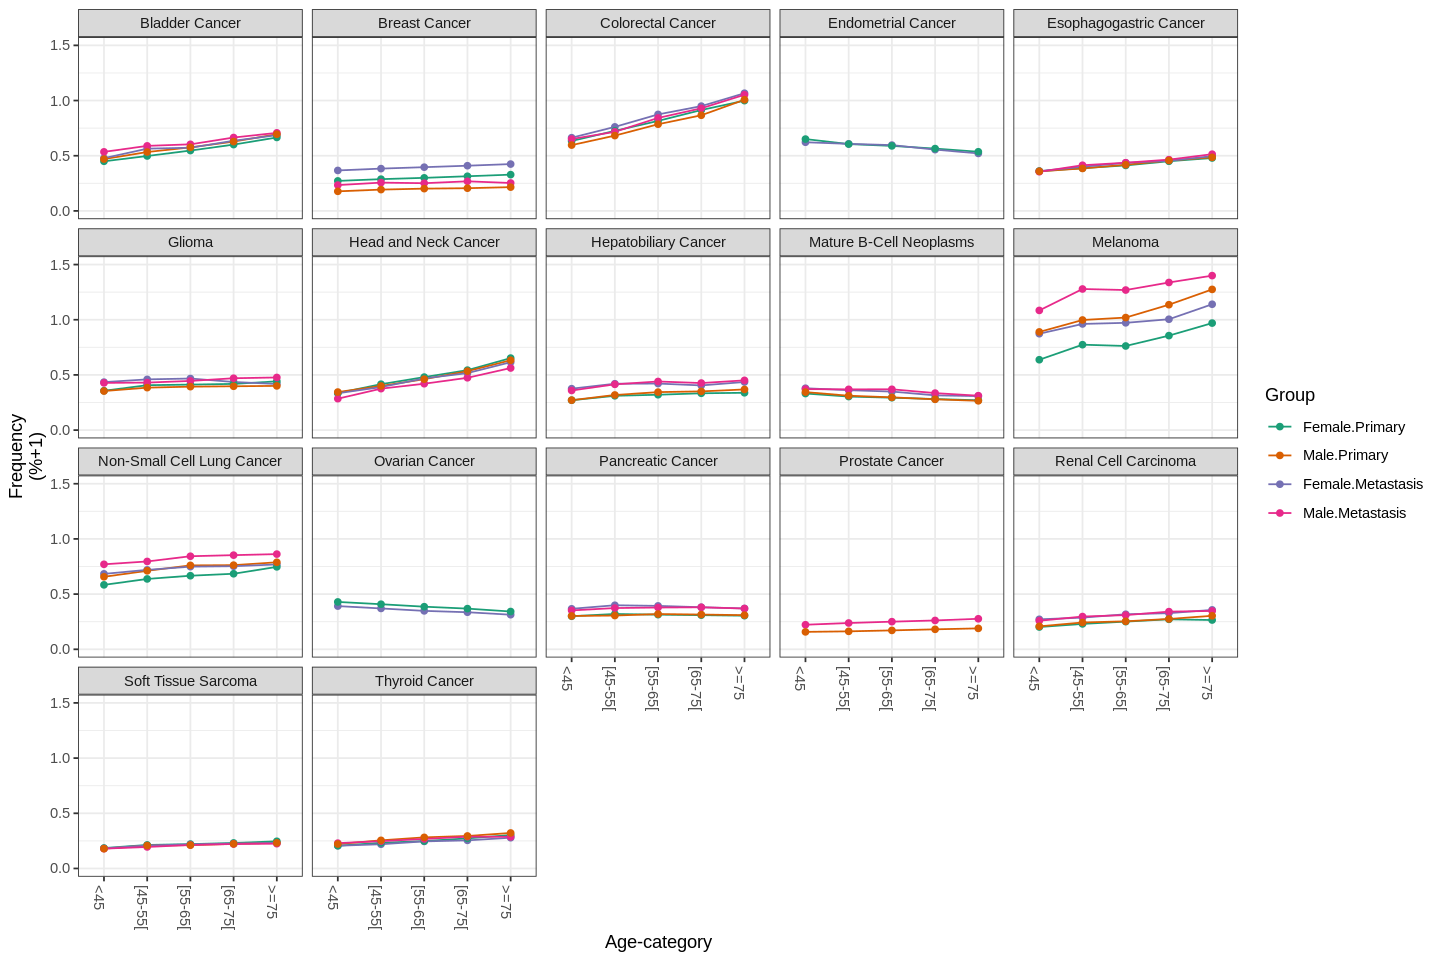

In [51]:
options(repr.plot.width=12, repr.plot.height=8)

cancer_linear_expectation$SEX <- factor(cancer_linear_expectation$SEX, levels = c("Female", "Male"))
cancer_linear_expectation$SAMPLE_TYPE <- factor(cancer_linear_expectation$SAMPLE_TYPE, levels = c("Primary", "Metastasis"))

# Plotting linear-expectation
ggplot(cancer_linear_expectation, aes(x = age_interval, y = mean_exp, group=interaction(SEX, SAMPLE_TYPE), colour=interaction(SEX, SAMPLE_TYPE))) +
geom_line() +
geom_point() +
theme_bw() +
scale_color_brewer(palette = "Dark2") +
xlab('Age-category') +
ylab('Frequency\n(%+1)')  +
labs(colour='Group') +
ylim(0,1.5) +
theme_bw() +
theme(axis.text.x=element_text(angle = -90, hjust = 0)) +
facet_wrap(~CANCER_TYPE)